## clustering clients

<img src="clustering-clients.webp" alt="clustering-clients" width="350">

*packages*

In [1]:
# packages
import pandas as pd
import numpy as np
import psycopg2
from sqlalchemy import create_engine
import os, yaml, requests
np.random.seed(42)

# scikit learn
from sklearn.preprocessing import OrdinalEncoder
from sklearn.metrics import silhouette_score
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import DBSCAN

# pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

c:\users\migue\appdata\local\programs\python\python39\lib\site-packages\numpy\_distributor_init.py:30: UserWarning: loaded more than 1 DLL from .libs:
c:\users\migue\appdata\local\programs\python\python39\lib\site-packages\numpy\.libs\libopenblas.FB5AE2TYXYH2IJRDKGDGQ3XBKLKTF43H.gfortran-win_amd64.dll
c:\users\migue\appdata\local\programs\python\python39\lib\site-packages\numpy\.libs\libopenblas.WCDJNK7YVMPZQ2ME2ZZHJJRJ3JIKNDB7.gfortran-win_amd64.dll
c:\users\migue\appdata\local\programs\python\python39\lib\site-packages\numpy\.libs\libopenblas64__v0.3.21-gcc_10_3_0.dll
  warnings.warn("loaded more than 1 DLL from .libs:"
c:\users\migue\appdata\local\programs\python\python39\lib\site-packages\requests\__init__.py:102: RequestsDependencyWarning: urllib3 (1.26.6) or chardet (5.2.0)/charset_normalizer (2.0.4) doesn't match a supported version!
  warnings.warn("urllib3 ({}) or chardet ({})/charset_normalizer ({}) doesn't match a supported "


*functions*

In [2]:
def read_yaml_file(yaml_file):
    """ load yaml cofigurations """

    config = None
    try:
        with open(yaml_file, 'r') as f:
            config = yaml.safe_load(f)
    except:
        raise FileNotFoundError('Couldnt load the file')

    return config


def get_db_conn_post(creds_file):
    """ Get an authenticated psycopg db connection, given a credentials file"""
    creds = read_yaml_file(creds_file)['db']

    connection = psycopg2.connect(
        user=creds['user'],
        password=creds['pass'],
        host=creds['host'],
        port=creds['port'],
        database=creds['db']
    )

    return connection

*create the connection to the db*

In [3]:
db_conn_post = get_db_conn_post("key_postgresql.yaml")

*get all the data from the db*

In [4]:
q = """
    select
            *
    from
            kaggle_data.revenue_forecast.data;
"""

df_raw = pd.read_sql(sql = q, con = db_conn_post)
df_raw.head(3)

C:\Users\migue\AppData\Local\Temp/ipykernel_6780/1983217797.py:8: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df_raw = pd.read_sql(sql = q, con = db_conn_post)


,Number_of_Customers,Menu_Price,Marketing_Spend,Cuisine_Type,Average_Customer_Spending,Promotions,Reviews,Monthly_Revenue
0,61,43.117635,12.663793,Japanese,36.236133,0,45,350.912040
1,24,40.020077,4.577892,Italian,17.952562,0,36,221.319091
2,81,41.981485,4.652911,Japanese,22.600420,1,91,326.529763


In [5]:
df=df_raw.copy()

*encoding data*

In [6]:
ordinal_encoder=OrdinalEncoder()
df['cuisine_encode']=ordinal_encoder.fit_transform(df[['Cuisine_Type']])
df.head(1)

,Number_of_Customers,Menu_Price,Marketing_Spend,Cuisine_Type,Average_Customer_Spending,Promotions,Reviews,Monthly_Revenue,cuisine_encode
0,61,43.117635,12.663793,Japanese,36.236133,0,45,350.91204,2.0


In [7]:
cuisine_type=df[['Cuisine_Type', 'cuisine_encode']].drop_duplicates(inplace=False)
cuisine_type

,Cuisine_Type,cuisine_encode
0,Japanese,2.0
1,Italian,1.0
5,American,0.0
10,Mexican,3.0


In [8]:
cols=['Cuisine_Type', 'Promotions']
df.drop(columns=cols,inplace=True)
df.head(2)

,Number_of_Customers,Menu_Price,Marketing_Spend,Average_Customer_Spending,Reviews,Monthly_Revenue,cuisine_encode
0,61,43.117635,12.663793,36.236133,45,350.912040,2.0
1,24,40.020077,4.577892,17.952562,36,221.319091,1.0


*scaling data*

In [9]:
scaler = StandardScaler()
df_scaled = scaler.fit_transform(df)

**`clustering k-means`**

In [10]:
clusters = [2, 3, 4, 5, 7, 10]
kmeans_per_k = [KMeans(n_clusters = k, init = 'k-means++', n_init = 'auto', random_state = 42).fit(df_scaled)
                for k in clusters]
inertias = [model.inertia_ for model in kmeans_per_k]

*`inertias`*

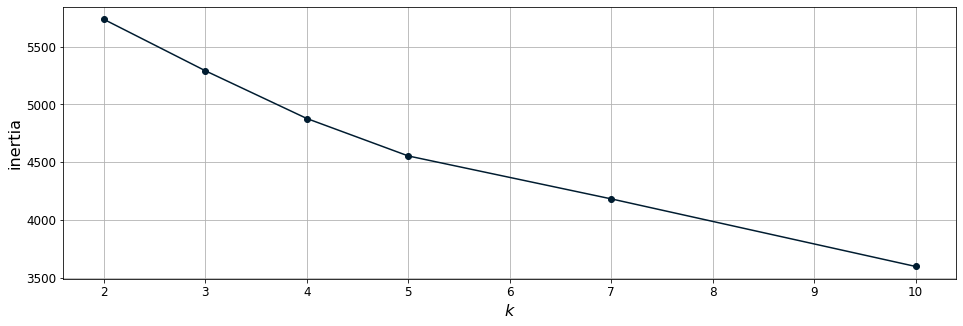

In [11]:
plt.figure(figsize = (16,5))
plt.plot(clusters, inertias, "o-", color='#001C30')
plt.xlabel("$k$", fontsize = 16)
plt.ylabel("inertia", fontsize = 16)
plt.grid(True)
plt.show()

*`silhouette score`*

In [12]:
silhouette_scores = [silhouette_score(df_scaled, model.labels_)
                     for model in kmeans_per_k]

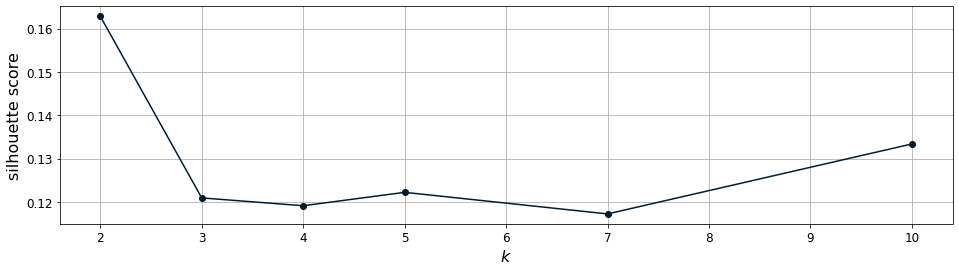

In [13]:
plt.figure(figsize = (16,4))
plt.plot(clusters, silhouette_scores, "o-", color='#001C30')
plt.xlabel("$k$", fontsize = 16)
plt.ylabel("silhouette score", fontsize = 16)
plt.grid(True)
plt.show()

*`davies-bouldin score`*

In [14]:
davies_bouldin_scores = [davies_bouldin_score(df_scaled, model.labels_)
                         for model in kmeans_per_k]

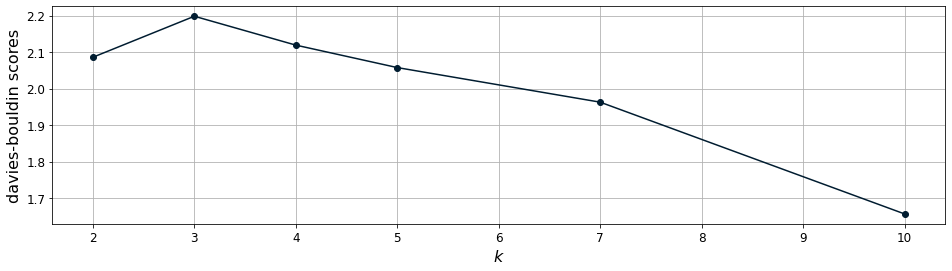

In [15]:
plt.figure(figsize = (16,4))
plt.plot(clusters, davies_bouldin_scores, "o-", color='#001C30')
plt.xlabel("$k$", fontsize = 16)
plt.ylabel("davies-bouldin scores", fontsize = 16)
plt.grid(True)
plt.show()

*`calinski-harabasz score score`*

In [16]:
calinski_harabasz_scores = [calinski_harabasz_score(df_scaled, model.labels_)
                            for model in kmeans_per_k]

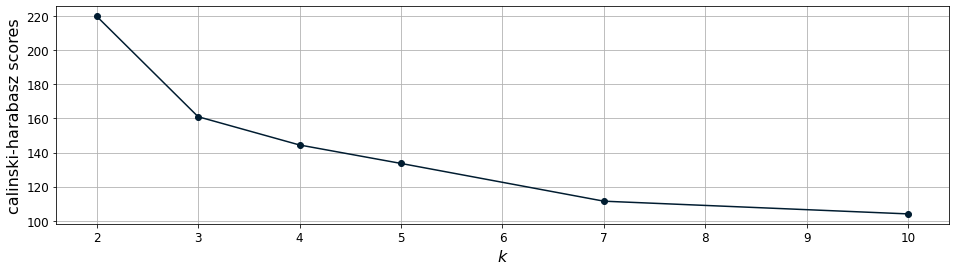

In [17]:
plt.figure(figsize = (16,4))
plt.plot(clusters, calinski_harabasz_scores, "o-", color='#001C30')
plt.xlabel("$k$", fontsize = 16)
plt.ylabel("calinski-harabasz scores", fontsize = 16)
plt.grid(True)
plt.show()

In [18]:
k = 5
kmeans = KMeans(n_clusters = k, 
                init = 'k-means++', 
                n_init = 'auto', 
                random_state = 42)

y_pred = kmeans.fit_predict(df_scaled)

In [19]:
silhouette_avg = silhouette_score(df_scaled, kmeans.labels_)
db_score = davies_bouldin_score(df_scaled, kmeans.labels_)
calinski_harabasz = calinski_harabasz_score(df_scaled, kmeans.labels_)

print(f"K-means inertia: {kmeans.inertia_}")
print(f"Silhouette Score: {silhouette_avg}")
print(f"Davies-Bouldin Score: {db_score}")
print(f"Calinski-Harabasz Score: {calinski_harabasz}")

K-means inertia: 4554.115170669989
Silhouette Score: 0.12221224763216247
Davies-Bouldin Score: 2.0576764003357058
Calinski-Harabasz Score: 133.59650085580336


In [20]:
df['cluster'] = kmeans.labels_
df.head(1)

,Number_of_Customers,Menu_Price,Marketing_Spend,Average_Customer_Spending,Reviews,Monthly_Revenue,cuisine_encode,cluster
0,61,43.117635,12.663793,36.236133,45,350.91204,2.0,3


In [21]:
df=df.merge(cuisine_type, on='cuisine_encode', how='left')
df.head(1)

,Number_of_Customers,Menu_Price,Marketing_Spend,Average_Customer_Spending,Reviews,Monthly_Revenue,cuisine_encode,cluster,Cuisine_Type
0,61,43.117635,12.663793,36.236133,45,350.91204,2.0,3,Japanese


In [22]:
df['cluster'].unique()

array([3, 1, 4, 0, 2])

In [23]:
df['cluster'].value_counts()

cluster
4    226
0    217
1    215
3    180
2    162
Name: count, dtype: int64

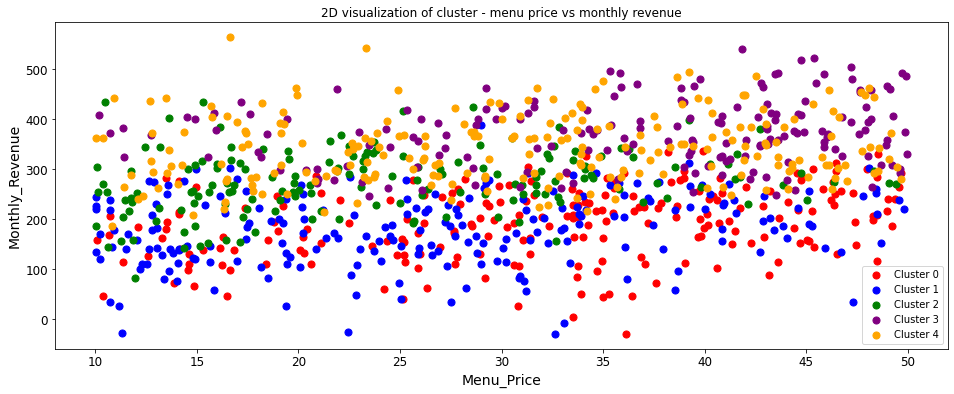

In [24]:
fig, ax = plt.subplots(figsize=(16,6))
colors = {0: 'red', 
          1: 'blue', 
          2: 'green', 
          3: 'purple',
          4: 'orange'}

cols=['Menu_Price', 'Monthly_Revenue', 'cluster']
for cluster, group in df[cols].groupby('cluster'):
    group.plot(ax=ax, 
               kind='scatter', 
               x='Menu_Price', 
               y='Monthly_Revenue', 
               s=50,
               label=f'Cluster {cluster}', 
               color=colors[cluster])

plt.title('2D visualization of cluster - menu price vs monthly revenue')
plt.show()

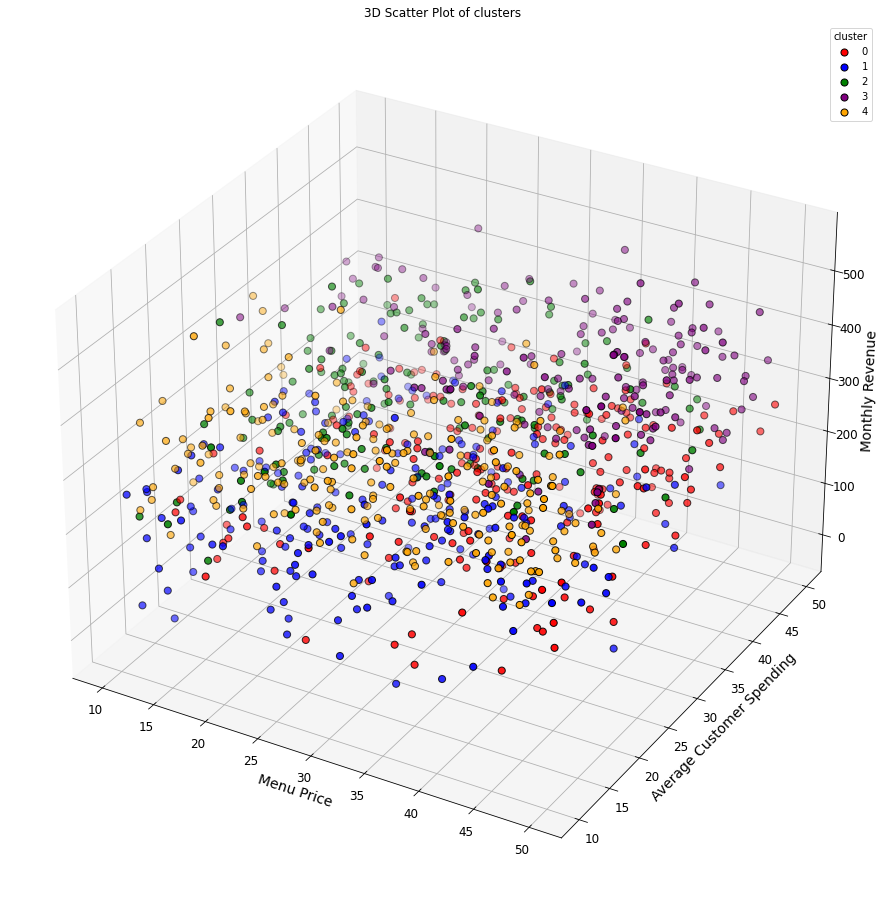

In [25]:
fig = plt.figure(figsize=(40, 16))
ax = fig.add_subplot(111, projection='3d')

colors = {0: 'red', 
          1: 'blue', 
          2: 'green', 
          3: 'purple',
          4: 'orange'}

for cluster, group in df.groupby('cluster'):
    ax.scatter(group['Menu_Price'], 
               group['Average_Customer_Spending'], 
               group['Monthly_Revenue'], 
               c=colors[cluster], 
               label=cluster, 
               s=50, 
               edgecolors='k')

ax.set_xlabel('Menu Price')
ax.set_ylabel('Average Customer Spending')
ax.set_zlabel('Monthly Revenue')
ax.set_title('3D Scatter Plot of clusters')
ax.legend(title='cluster')
plt.show()

The clusters for revenue versus menu price clearly split based on the revenue of each site, which is expected. However, according to the metrics above, these clusters are underperforming.

*`new features`*

In [26]:
df.drop(columns=['cluster'],inplace=True)
df.head(1)

,Number_of_Customers,Menu_Price,Marketing_Spend,Average_Customer_Spending,Reviews,Monthly_Revenue,cuisine_encode,Cuisine_Type
0,61,43.117635,12.663793,36.236133,45,350.91204,2.0,Japanese


Customer Spending Ratio:
- Calculate the marketing expenditure per customer. This metric can reveal how efficiently marketing resources are being used to attract customers.

In [27]:
df['marketing_spend_per_customer'] = df['Marketing_Spend'] / df['Number_of_Customers']
df.head(1)

,Number_of_Customers,Menu_Price,Marketing_Spend,Average_Customer_Spending,Reviews,Monthly_Revenue,cuisine_encode,Cuisine_Type,marketing_spend_per_customer
0,61,43.117635,12.663793,36.236133,45,350.91204,2.0,Japanese,0.207603


Customer Profitability:
- This metric reflects the revenue generated by each customer. It is useful for identifying the value of customers in terms of their contribution to total revenue.

In [28]:
df['revenue_per_customer'] = df['Monthly_Revenue'] / df['Number_of_Customers']
df.head(1)

,Number_of_Customers,Menu_Price,Marketing_Spend,Average_Customer_Spending,Reviews,Monthly_Revenue,cuisine_encode,Cuisine_Type,marketing_spend_per_customer,revenue_per_customer
0,61,43.117635,12.663793,36.236133,45,350.91204,2.0,Japanese,0.207603,5.752656


Review-to-Revenue Conversion Ratio:
- Examine the relationship between the number of reviews and monthly revenue. A high ratio could indicate a strong influence of reviews on revenue, which can be useful for segmenting customers based on market response.

In [29]:
df['reviews_to_revenue_ratio'] = df['Monthly_Revenue'] / df['Reviews']
df.head(1)

,Number_of_Customers,Menu_Price,Marketing_Spend,Average_Customer_Spending,Reviews,Monthly_Revenue,cuisine_encode,Cuisine_Type,marketing_spend_per_customer,revenue_per_customer,reviews_to_revenue_ratio
0,61,43.117635,12.663793,36.236133,45,350.91204,2.0,Japanese,0.207603,5.752656,7.798045


Spend Efficiency:
- Calculate the efficiency of marketing spend by comparing marketing expenses with monthly revenue. A higher value may indicate greater efficiency in converting marketing spend into revenue.

In [30]:
df['marketing_efficiency'] = df['Monthly_Revenue'] / df['Marketing_Spend']
df.head(1)

,Number_of_Customers,Menu_Price,Marketing_Spend,Average_Customer_Spending,Reviews,Monthly_Revenue,cuisine_encode,Cuisine_Type,marketing_spend_per_customer,revenue_per_customer,reviews_to_revenue_ratio,marketing_efficiency
0,61,43.117635,12.663793,36.236133,45,350.91204,2.0,Japanese,0.207603,5.752656,7.798045,27.70987


Menu Price Ratio:
- Compare the menu price with the average customer spending. A value greater than 1 could indicate that customers are willing to pay more than the average menu price, suggesting a less price-sensitive clientele.

In [31]:
df['relative_menu_price'] = df['Average_Customer_Spending'] / df['Menu_Price'] 
df.head(1)

,Number_of_Customers,Menu_Price,Marketing_Spend,Average_Customer_Spending,Reviews,Monthly_Revenue,cuisine_encode,Cuisine_Type,marketing_spend_per_customer,revenue_per_customer,reviews_to_revenue_ratio,marketing_efficiency,relative_menu_price
0,61,43.117635,12.663793,36.236133,45,350.91204,2.0,Japanese,0.207603,5.752656,7.798045,27.70987,0.840402


*drop Cuisine Type*

In [32]:
df.drop(columns=['Cuisine_Type'], inplace=True)

In [33]:
df.describe()

c:\users\migue\appdata\local\programs\python\python39\lib\site-packages\pandas\core\nanops.py:1010: RuntimeWarning: invalid value encountered in subtract
  sqr = _ensure_numeric((avg - values) ** 2)


,Number_of_Customers,Menu_Price,Marketing_Spend,Average_Customer_Spending,Reviews,Monthly_Revenue,cuisine_encode,marketing_spend_per_customer,revenue_per_customer,reviews_to_revenue_ratio,marketing_efficiency,relative_menu_price
count,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000
mean,53.271000,30.219120,9.958726,29.477085,49.837000,268.724172,1.506000,0.272909,5.952150,inf,123.747311,1.163386
std,26.364914,11.278760,5.845586,11.471686,29.226334,103.982950,1.123934,0.287215,3.195084,NaN,1025.080620,0.742365
min,10.000000,10.009501,0.003768,10.037177,0.000000,-28.977809,0.000000,0.000198,-2.761028,-2.410074,-35.653095,0.215908
25%,30.000000,20.396828,4.690724,19.603041,24.000000,197.103642,0.000000,0.089605,4.082428,3.275355,17.850756,0.650949
50%,54.000000,30.860614,10.092047,29.251365,50.000000,270.213964,2.000000,0.187675,5.123055,5.501988,27.244532,0.965697
75%,74.000000,39.843868,14.992436,39.553220,76.000000,343.395793,2.250000,0.338985,6.801814,11.373713,53.624091,1.435539
max,99.000000,49.974140,19.994276,49.900725,99.000000,563.381332,3.000000,1.756806,26.167213,inf,29425.463498,4.485616


In [34]:
df.loc[np.isinf(df['reviews_to_revenue_ratio'])]

,Number_of_Customers,Menu_Price,Marketing_Spend,Average_Customer_Spending,Reviews,Monthly_Revenue,cuisine_encode,marketing_spend_per_customer,revenue_per_customer,reviews_to_revenue_ratio,marketing_efficiency,relative_menu_price
30,69,29.816945,0.852664,32.954024,0,203.959352,1.0,0.012357,2.955933,inf,239.202438,1.105211
179,86,46.424960,14.990910,33.113119,0,340.626718,0.0,0.174313,3.960776,inf,22.722218,0.713261
458,25,41.552279,15.184975,27.234331,0,212.936556,0.0,0.607399,8.517462,inf,14.022846,0.655423
543,95,36.279354,2.633869,37.847698,0,339.617381,2.0,0.027725,3.574920,inf,128.942408,1.043230
768,59,16.737775,18.374694,47.555079,0,256.393288,2.0,0.311435,4.345649,inf,13.953608,2.841183


*replace inf values*

In [35]:
df.loc[np.isinf(df['reviews_to_revenue_ratio']), 'reviews_to_revenue_ratio'] = 0

In [36]:
df.describe()

,Number_of_Customers,Menu_Price,Marketing_Spend,Average_Customer_Spending,Reviews,Monthly_Revenue,cuisine_encode,marketing_spend_per_customer,revenue_per_customer,reviews_to_revenue_ratio,marketing_efficiency,relative_menu_price
count,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000
mean,53.271000,30.219120,9.958726,29.477085,49.837000,268.724172,1.506000,0.272909,5.952150,14.330490,123.747311,1.163386
std,26.364914,11.278760,5.845586,11.471686,29.226334,103.982950,1.123934,0.287215,3.195084,38.888497,1025.080620,0.742365
min,10.000000,10.009501,0.003768,10.037177,0.000000,-28.977809,0.000000,0.000198,-2.761028,-2.410074,-35.653095,0.215908
25%,30.000000,20.396828,4.690724,19.603041,24.000000,197.103642,0.000000,0.089605,4.082428,3.239839,17.850756,0.650949
50%,54.000000,30.860614,10.092047,29.251365,50.000000,270.213964,2.000000,0.187675,5.123055,5.450810,27.244532,0.965697
75%,74.000000,39.843868,14.992436,39.553220,76.000000,343.395793,2.250000,0.338985,6.801814,11.046557,53.624091,1.435539
max,99.000000,49.974140,19.994276,49.900725,99.000000,563.381332,3.000000,1.756806,26.167213,447.230857,29425.463498,4.485616


*scaling data*

In [37]:
scaler = StandardScaler()
df_scaled = scaler.fit_transform(df)

**`clustering k-means`**

In [38]:
clusters = [2, 3, 4, 5, 7, 10]
kmeans_per_k = [KMeans(n_clusters = k, init = 'k-means++', n_init = 'auto', random_state = 42).fit(df_scaled)
                for k in clusters]
inertias = [model.inertia_ for model in kmeans_per_k]

*`inertias`*

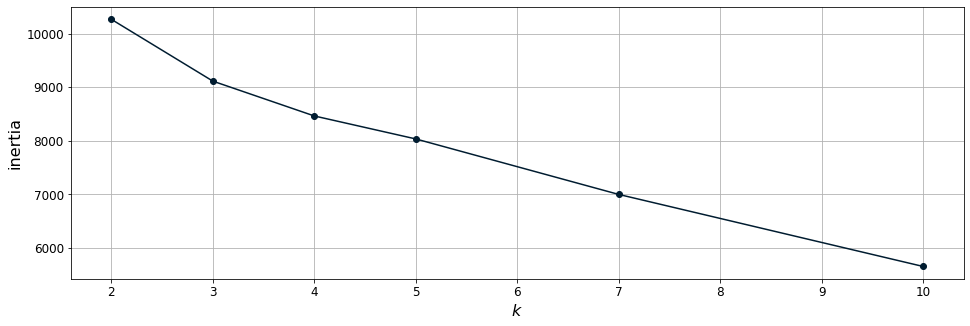

In [39]:
plt.figure(figsize = (16,5))
plt.plot(clusters, inertias, "o-", color='#001C30')
plt.xlabel("$k$", fontsize = 16)
plt.ylabel("inertia", fontsize = 16)
plt.grid(True)
plt.show()

*`silhouette score`*

In [40]:
silhouette_scores = [silhouette_score(df_scaled, model.labels_)
                     for model in kmeans_per_k]

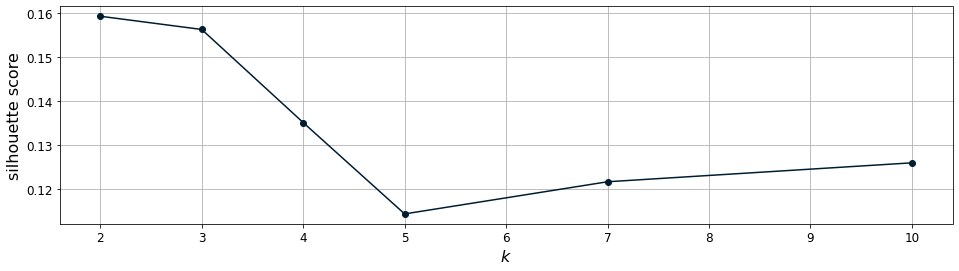

In [41]:
plt.figure(figsize = (16,4))
plt.plot(clusters, silhouette_scores, "o-", color='#001C30')
plt.xlabel("$k$", fontsize = 16)
plt.ylabel("silhouette score", fontsize = 16)
plt.grid(True)
plt.show()

*`davies-bouldin score`*

In [42]:
davies_bouldin_scores = [davies_bouldin_score(df_scaled, model.labels_)
                         for model in kmeans_per_k]

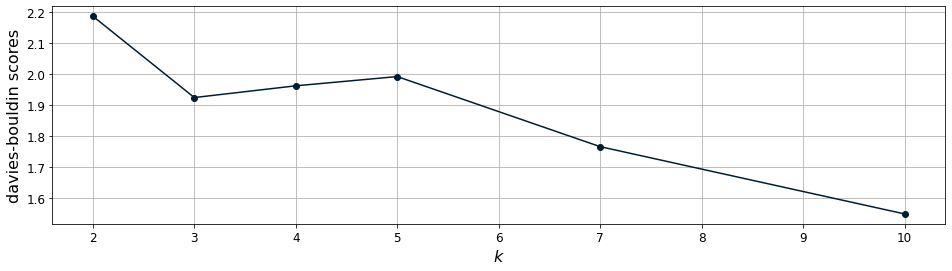

In [43]:
plt.figure(figsize = (16,4))
plt.plot(clusters, davies_bouldin_scores, "o-", color='#001C30')
plt.xlabel("$k$", fontsize = 16)
plt.ylabel("davies-bouldin scores", fontsize = 16)
plt.grid(True)
plt.show()

*`calinski-harabasz score score`*

In [44]:
calinski_harabasz_scores = [calinski_harabasz_score(df_scaled, model.labels_)
                            for model in kmeans_per_k]

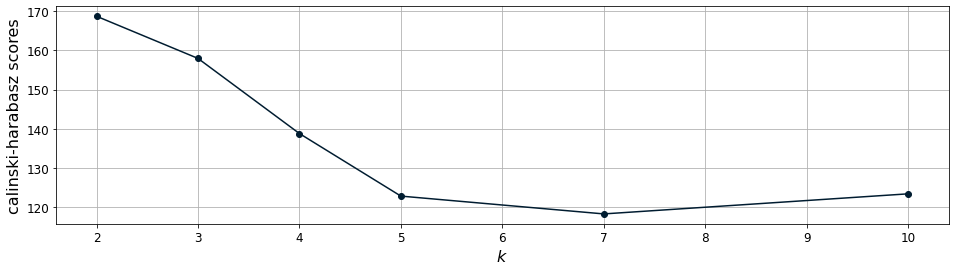

In [45]:
plt.figure(figsize = (16,4))
plt.plot(clusters, calinski_harabasz_scores, "o-", color='#001C30')
plt.xlabel("$k$", fontsize = 16)
plt.ylabel("calinski-harabasz scores", fontsize = 16)
plt.grid(True)
plt.show()

In [46]:
k = 3
kmeans = KMeans(n_clusters = k, 
                init = 'k-means++', 
                n_init = 'auto', 
                random_state = 42)

y_pred = kmeans.fit_predict(df_scaled)

In [47]:
silhouette_avg = silhouette_score(df_scaled, kmeans.labels_)
db_score = davies_bouldin_score(df_scaled, kmeans.labels_)
calinski_harabasz = calinski_harabasz_score(df_scaled, kmeans.labels_)

print(f"K-means inertia: {kmeans.inertia_}")
print(f"Silhouette Score: {silhouette_avg}")
print(f"Davies-Bouldin Score: {db_score}")
print(f"Calinski-Harabasz Score: {calinski_harabasz}")

K-means inertia: 9112.513842088252
Silhouette Score: 0.1563177960468968
Davies-Bouldin Score: 1.9249673046098719
Calinski-Harabasz Score: 157.95990817273153


In [48]:
df['cluster'] = kmeans.labels_
df.head(1)

,Number_of_Customers,Menu_Price,Marketing_Spend,Average_Customer_Spending,Reviews,Monthly_Revenue,cuisine_encode,marketing_spend_per_customer,revenue_per_customer,reviews_to_revenue_ratio,marketing_efficiency,relative_menu_price,cluster
0,61,43.117635,12.663793,36.236133,45,350.91204,2.0,0.207603,5.752656,7.798045,27.70987,0.840402,1


In [49]:
df=df.merge(cuisine_type, on='cuisine_encode', how='left')
df.head(1)

,Number_of_Customers,Menu_Price,Marketing_Spend,Average_Customer_Spending,Reviews,Monthly_Revenue,cuisine_encode,marketing_spend_per_customer,revenue_per_customer,reviews_to_revenue_ratio,marketing_efficiency,relative_menu_price,cluster,Cuisine_Type
0,61,43.117635,12.663793,36.236133,45,350.91204,2.0,0.207603,5.752656,7.798045,27.70987,0.840402,1,Japanese


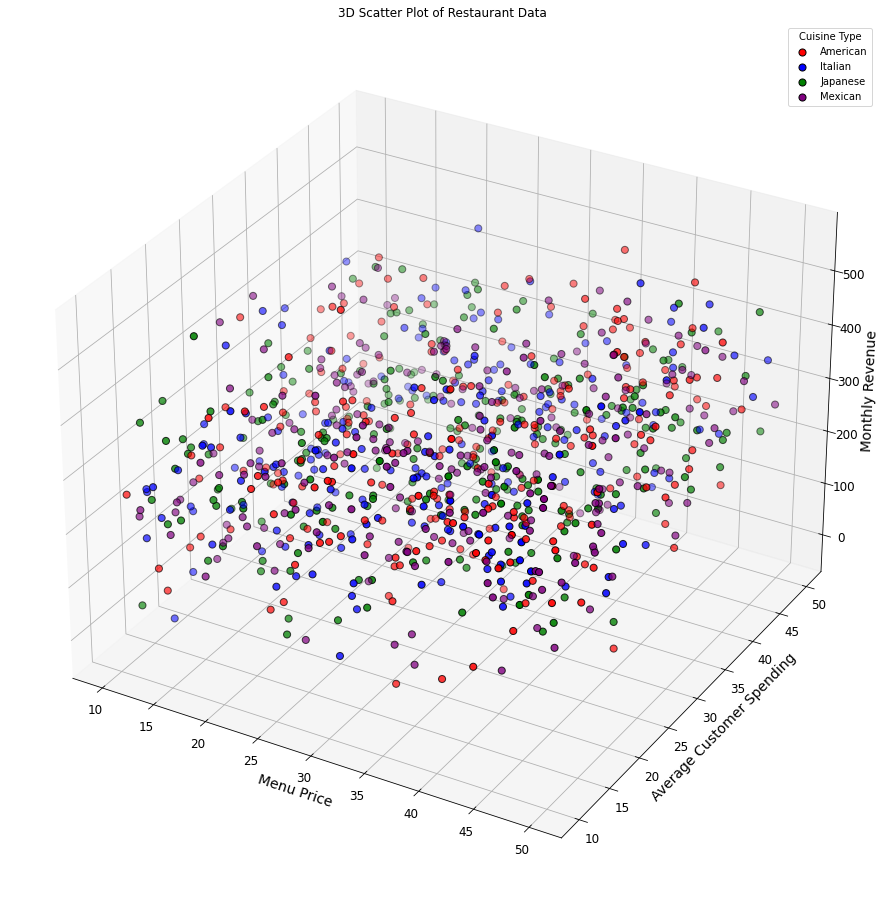

In [50]:
# Crear un gráfico 3D
fig = plt.figure(figsize=(40, 16))
ax = fig.add_subplot(111, projection='3d')

# Colores para cada tipo de cocina
colors = {'American': 'red', 
          'Italian': 'blue', 
          'Japanese': 'green', 
          'Mexican': 'purple'}

# Agrupar por tipo de cocina y graficar
for cuisine, group in df.groupby('Cuisine_Type'):
    ax.scatter(group['Menu_Price'], group['Average_Customer_Spending'], group['Monthly_Revenue'], 
               c=colors[cuisine], label=cuisine, s=50, edgecolors='k')

ax.set_xlabel('Menu Price')
ax.set_ylabel('Average Customer Spending')
ax.set_zlabel('Monthly Revenue')
ax.set_title('3D Scatter Plot of Restaurant Data')
ax.legend(title='Cuisine Type')

plt.show()

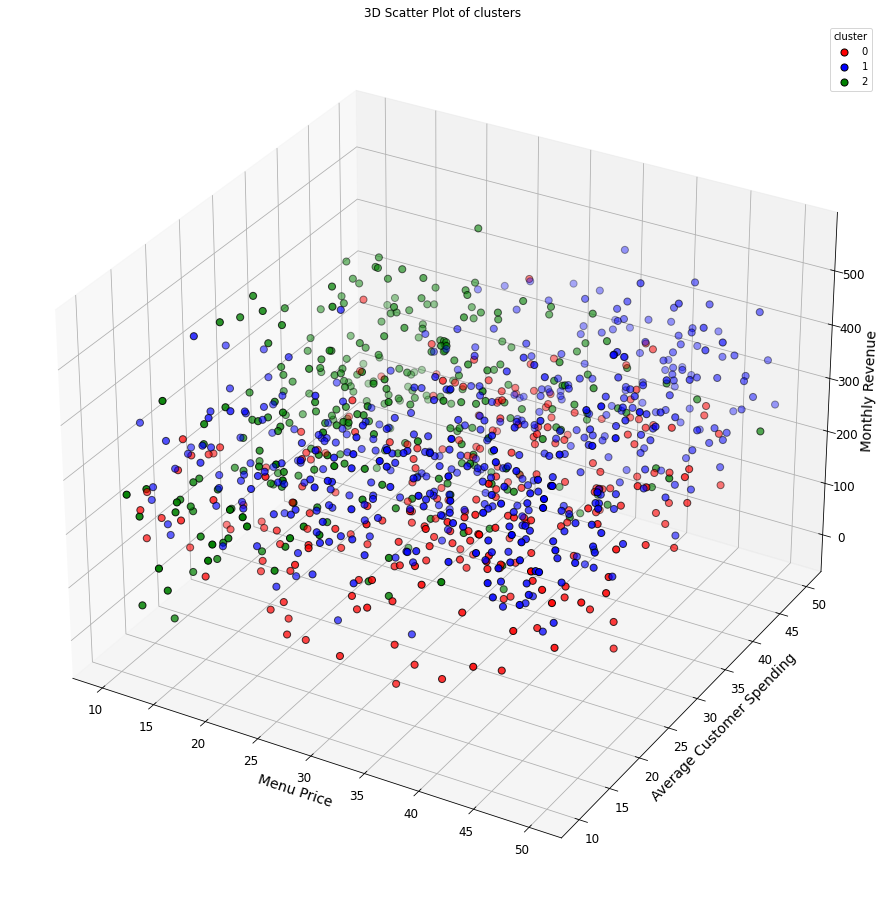

In [51]:
fig = plt.figure(figsize=(40, 16))
ax = fig.add_subplot(111, projection='3d')

colors = {0: 'red', 
          1: 'blue', 
          2: 'green', 
          3: 'purple',
          4: 'orange'}

for cluster, group in df.groupby('cluster'):
    ax.scatter(group['Menu_Price'], 
               group['Average_Customer_Spending'], 
               group['Monthly_Revenue'], 
               c=colors[cluster], 
               label=cluster, 
               s=50, 
               edgecolors='k')

ax.set_xlabel('Menu Price')
ax.set_ylabel('Average Customer Spending')
ax.set_zlabel('Monthly Revenue')
ax.set_title('3D Scatter Plot of clusters')
ax.legend(title='cluster')
plt.show()

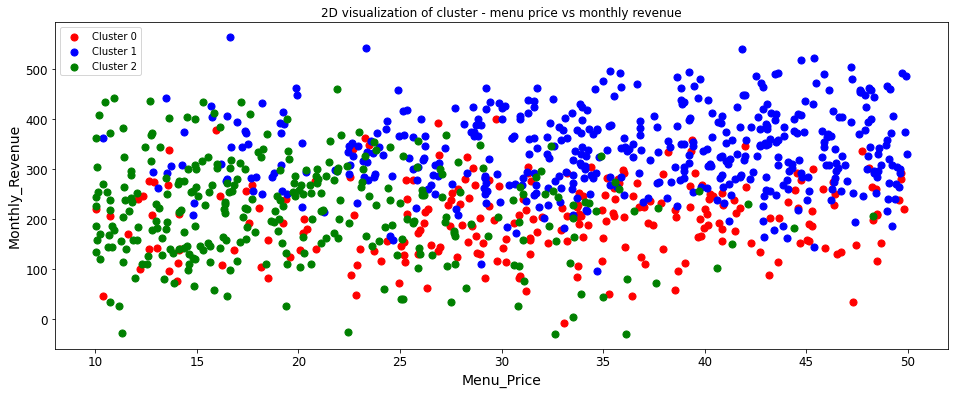

In [52]:
fig, ax = plt.subplots(figsize=(16,6))
colors = {0: 'red', 
          1: 'blue', 
          2: 'green', 
          3: 'purple',
          4: 'orange'}

cols=['Menu_Price', 'Monthly_Revenue', 'cluster']
for cluster, group in df[cols].groupby('cluster'):
    group.plot(ax=ax, 
               kind='scatter', 
               x='Menu_Price', 
               y='Monthly_Revenue', 
               s=50,
               label=f'Cluster {cluster}', 
               color=colors[cluster])

plt.title('2D visualization of cluster - menu price vs monthly revenue')
plt.show()

*`monthly revenue by cluster`*

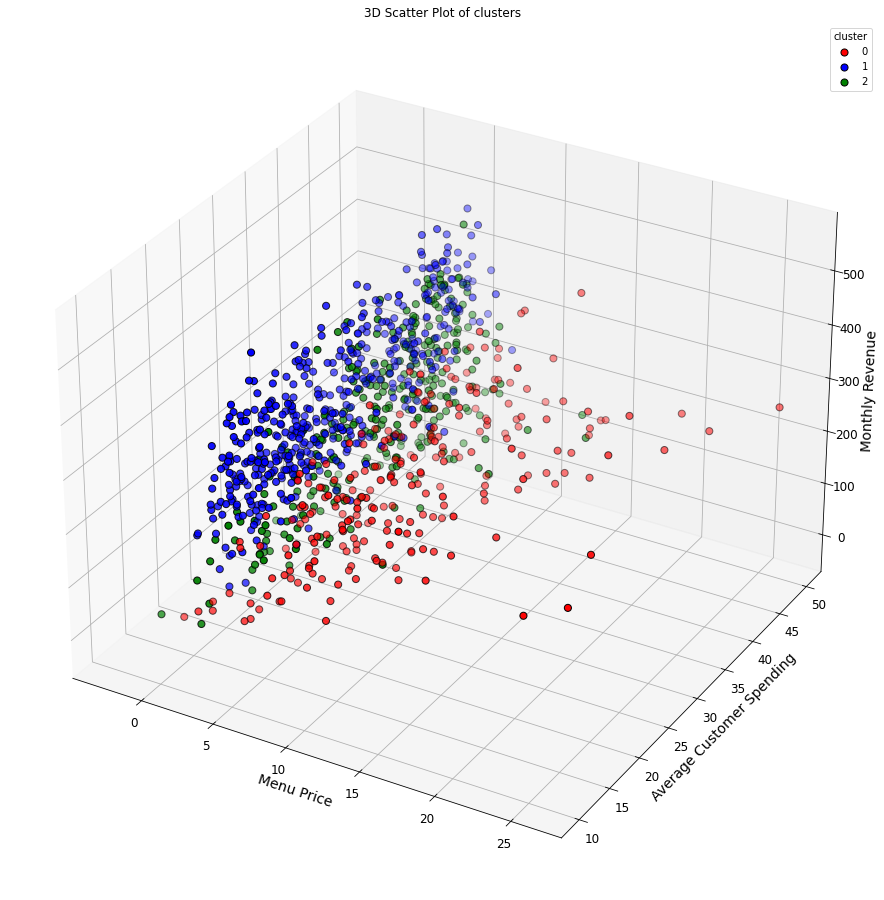

In [83]:
fig = plt.figure(figsize=(40, 16))
ax = fig.add_subplot(111, projection='3d')

colors = {0: 'red', 
          1: 'blue', 
          2: 'green', 
          3: 'purple',
          4: 'orange'}

for cluster, group in df.groupby('cluster'):
    ax.scatter(group['revenue_per_customer'], 
               group['Average_Customer_Spending'], 
               group['Monthly_Revenue'], 
               c=colors[cluster], 
               label=cluster, 
               s=50, 
               edgecolors='k')

ax.set_xlabel('Menu Price')
ax.set_ylabel('Average Customer Spending')
ax.set_zlabel('Monthly Revenue')
ax.set_title('3D Scatter Plot of clusters')
ax.legend(title='cluster')
plt.show()

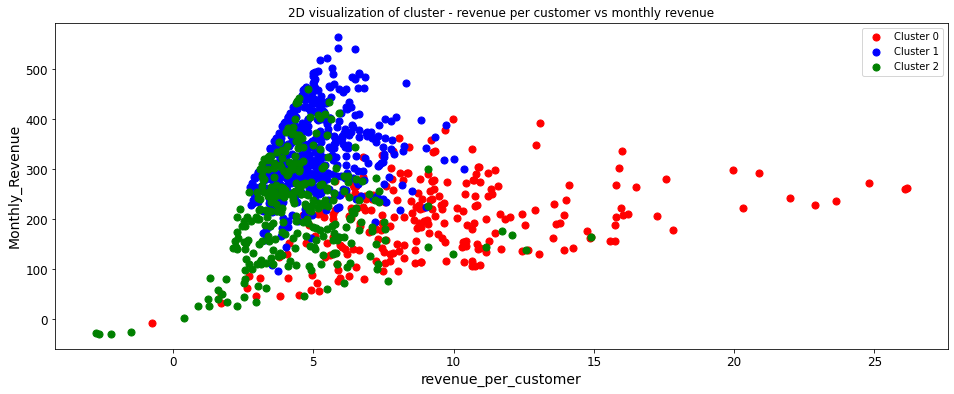

In [54]:
fig, ax = plt.subplots(figsize=(16,6))
colors = {0: 'red', 
          1: 'blue', 
          2: 'green', 
          3: 'purple',
          4: 'orange'}

cols=['revenue_per_customer', 'Monthly_Revenue', 'cluster']
for cluster, group in df[cols].groupby('cluster'):
    group.plot(ax=ax, 
               kind='scatter', 
               x='revenue_per_customer', 
               y='Monthly_Revenue', 
               s=50,
               label=f'Cluster {cluster}', 
               color=colors[cluster])

plt.title('2D visualization of cluster - revenue per customer vs monthly revenue')
plt.show()

In [55]:
df['cluster'].value_counts()

cluster
1    461
2    297
0    242
Name: count, dtype: int64

**`customer behavior`**

*number of customers*

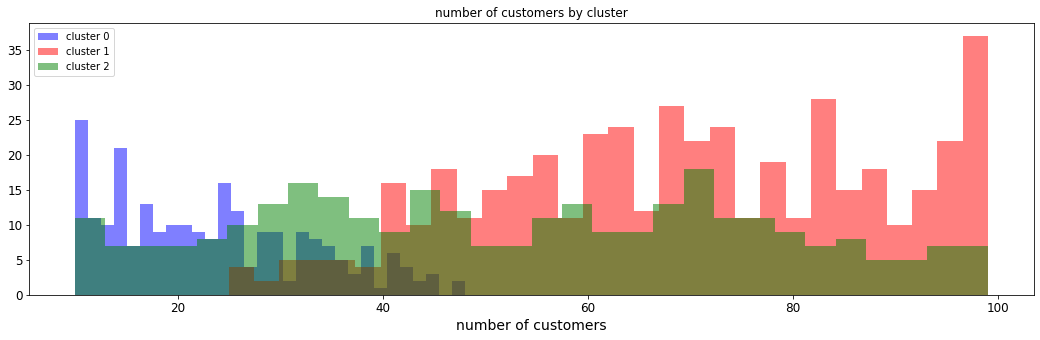

In [76]:
plt.figure(figsize=(18, 5))


for c in range(3):
    colors=['blue', 'red', 'green']
    condition=df['cluster']==c
    plt.hist(df['Number_of_Customers'][condition], 
             bins=30, 
             alpha=0.5, 
             label=f'cluster {c}', 
             color=colors[c])

plt.xlabel('number of customers')
plt.title('number of customers by cluster')
plt.legend()
plt.show()

*menu price*

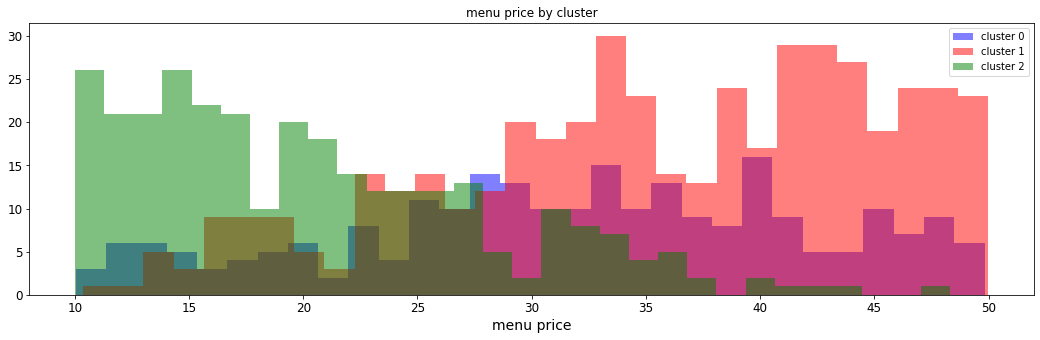

In [79]:
plt.figure(figsize=(18, 5))


for c in range(3):
    colors=['blue', 'red', 'green']
    condition=df['cluster']==c
    plt.hist(df['Menu_Price'][condition], 
             bins=30, 
             alpha=0.5, 
             label=f'cluster {c}', 
             color=colors[c])

plt.xlabel('menu price')
plt.title('menu price by cluster')
plt.legend()
plt.show()

*marketing spend*

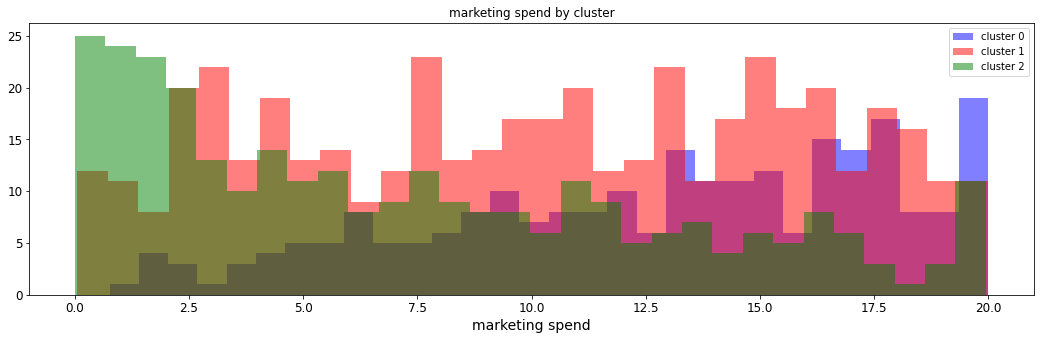

In [78]:
plt.figure(figsize=(18, 5))


for c in range(3):
    colors=['blue', 'red', 'green']
    condition=df['cluster']==c
    plt.hist(df['Marketing_Spend'][condition], 
             bins=30, 
             alpha=0.5, 
             label=f'cluster {c}', 
             color=colors[c])

plt.xlabel('marketing spend')
plt.title('marketing spend by cluster')
plt.legend()
plt.show()

*avg customer spending*

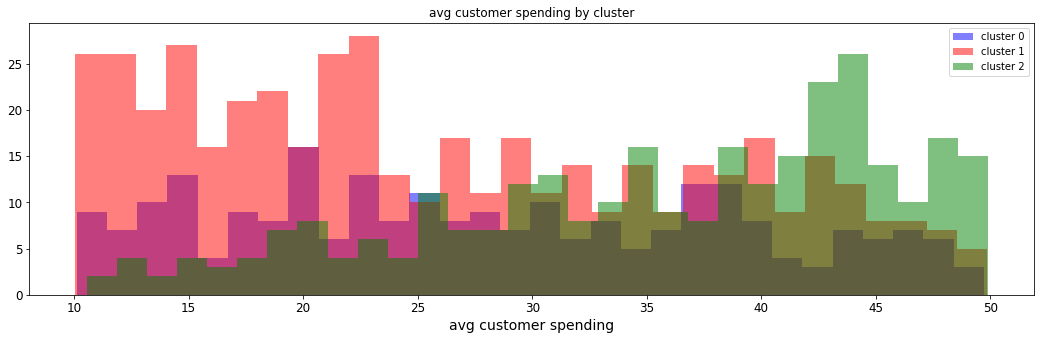

In [80]:
plt.figure(figsize=(18, 5))


for c in range(3):
    colors=['blue', 'red', 'green']
    condition=df['cluster']==c
    plt.hist(df['Average_Customer_Spending'][condition], 
             bins=30, 
             alpha=0.5, 
             label=f'cluster {c}', 
             color=colors[c])

plt.xlabel('avg customer spending')
plt.title('avg customer spending by cluster')
plt.legend()
plt.show()

*monthly revenue*

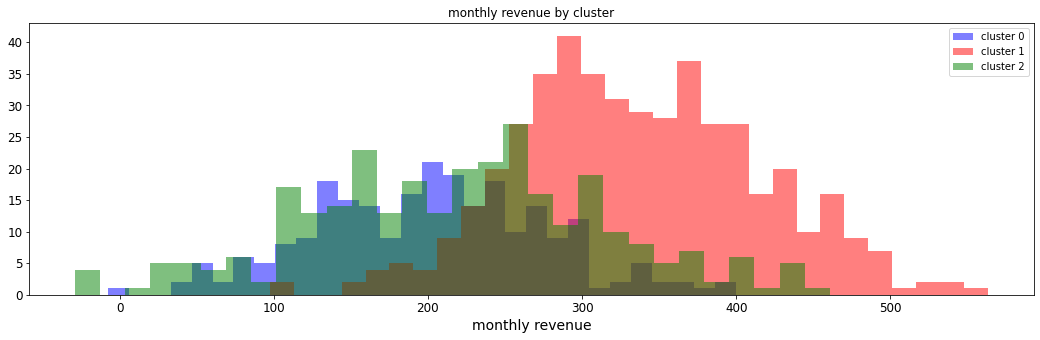

In [82]:
plt.figure(figsize=(18, 5))


for c in range(3):
    colors=['blue', 'red', 'green']
    condition=df['cluster']==c
    plt.hist(df['Monthly_Revenue'][condition], 
             bins=30, 
             alpha=0.5, 
             label=f'cluster {c}', 
             color=colors[c])

plt.xlabel('monthly revenue')
plt.title('monthly revenue by cluster')
plt.legend()
plt.show()

*clusters describe*

In [84]:
condition=df['cluster']==0
df[condition].describe()

,Number_of_Customers,Menu_Price,Marketing_Spend,Average_Customer_Spending,Reviews,Monthly_Revenue,cuisine_encode,marketing_spend_per_customer,revenue_per_customer,reviews_to_revenue_ratio,marketing_efficiency,relative_menu_price,cluster
count,242.000000,242.000000,242.000000,242.000000,242.000000,242.000000,242.000000,242.000000,242.000000,242.000000,242.000000,242.000000,242.0
mean,23.285124,31.995412,12.864627,28.116667,51.785124,200.698524,1.458678,0.633252,9.483217,8.305510,19.858751,0.977086,0.0
std,9.760477,10.034490,4.907847,10.876808,29.231287,73.729944,1.093335,0.359161,4.168624,18.224981,17.575450,0.521493,0.0
min,10.000000,10.044804,0.760437,10.108326,0.000000,-7.627382,0.000000,0.050696,-0.762738,-0.246045,-1.269160,0.231824,0.0
25%,15.000000,25.708274,9.299537,19.491605,26.000000,145.117496,0.250000,0.388253,6.757467,2.470846,11.849115,0.585998,0.0
50%,22.000000,32.954765,13.595812,27.180269,52.500000,204.434295,1.000000,0.544618,8.840054,3.802225,15.001606,0.902594,0.0
75%,30.000000,39.744359,17.001566,37.080795,78.000000,250.070275,2.000000,0.763096,10.886889,7.844528,20.614709,1.208410,0.0
max,48.000000,49.819220,19.989325,49.717739,99.000000,399.652200,3.000000,1.756806,26.167213,237.575904,148.875967,3.583066,0.0


In [85]:
condition=df['cluster']==1
df[condition].describe()

,Number_of_Customers,Menu_Price,Marketing_Spend,Average_Customer_Spending,Reviews,Monthly_Revenue,cuisine_encode,marketing_spend_per_customer,revenue_per_customer,reviews_to_revenue_ratio,marketing_efficiency,relative_menu_price,cluster
count,461.000000,461.000000,461.000000,461.000000,461.000000,461.000000,461.000000,461.000000,461.000000,461.000000,461.000000,461.000000,461.0
mean,69.394794,35.657445,10.228786,26.173690,46.360087,336.280213,1.561822,0.156037,5.064623,21.944079,82.485518,0.759583,1.0
std,18.811430,9.488411,5.570226,11.117066,29.417912,77.993604,1.145395,0.091172,1.316167,54.058657,310.213598,0.302578,0.0
min,25.000000,10.362896,0.057625,10.037177,0.000000,97.374702,0.000000,0.000686,2.749734,0.000000,10.680823,0.215908,1.0
25%,55.000000,29.233479,5.320386,16.698390,22.000000,282.543514,0.000000,0.082310,4.133503,4.705175,23.592151,0.503874,1.0
50%,70.000000,36.484480,10.508698,23.713559,43.000000,330.713819,2.000000,0.156906,4.900594,7.341481,32.153952,0.754385,1.0
75%,85.000000,43.462593,14.990910,35.442737,72.000000,389.540992,3.000000,0.211876,5.731409,15.409252,60.242418,0.967520,1.0
max,99.000000,49.974140,19.994276,49.872367,99.000000,563.381332,3.000000,0.396410,10.374438,447.230857,5779.916241,1.739307,1.0


In [86]:
condition=df['cluster']==2
df[condition].describe()

,Number_of_Customers,Menu_Price,Marketing_Spend,Average_Customer_Spending,Reviews,Monthly_Revenue,cuisine_encode,marketing_spend_per_customer,revenue_per_customer,reviews_to_revenue_ratio,marketing_efficiency,relative_menu_price,cluster
count,297.000000,297.000000,297.000000,297.000000,297.000000,297.000000,297.000000,297.000000,297.000000,297.000000,297.000000,297.000000,297.0
mean,52.676768,20.330465,7.171771,35.713064,53.646465,219.292765,1.457912,0.160705,4.452594,7.422007,272.443331,1.941963,2.0
std,24.044228,7.790067,5.717201,9.911330,28.385967,96.280097,1.114590,0.142838,1.984051,11.149593,1833.836023,0.778284,0.0
min,10.000000,10.009501,0.003768,10.575249,0.000000,-28.977809,0.000000,0.000198,-2.761028,-2.410074,-35.653095,0.661110,2.0
25%,33.000000,14.364385,2.219550,29.061059,26.000000,155.120985,0.000000,0.048245,3.376501,2.426804,18.966852,1.340265,2.0
50%,52.000000,18.988047,5.705807,38.037415,57.000000,221.861491,1.000000,0.128037,4.325979,4.000262,34.721282,1.803522,2.0
75%,72.000000,25.172228,11.203645,44.020169,77.000000,282.128302,2.000000,0.235981,5.403224,7.715706,88.929328,2.423645,2.0
max,99.000000,48.292916,19.941563,49.900725,99.000000,460.829895,3.000000,0.702743,14.891575,83.087873,29425.463498,4.485616,2.0
